In [ ]:

import pandas as pd
from bs4 import BeautifulSoup
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("Set2")



In [ ]:
html_files = [
    "09.04.25.htm", "10.04.25.htm", "11.04.25.htm",
    "12.04.25.htm", "14.04.25.htm", "15.04.25.htm"
]



In [ ]:
def parse_structured_html(filepath):
    with open(filepath, "r", encoding="utf-8", errors="ignore") as file:
        soup = BeautifulSoup(file, "html.parser")

    rows = soup.find_all("tr")
    parsed_data = []
    current_date = None
    current_time = None
    current_entry = {}

    for row in rows:
        cells = [cell.get_text(strip=True) for cell in row.find_all("td")]

        for text in cells:
            if "2025" in text:
                current_date = text.strip()
                break
        for text in cells:
            if "AM" in text or "PM" in text:
                current_time = text.strip()
                break

        if len(cells) >= 10 and cells[8] and cells[9].isdigit():
            current_entry = {
                "Date": current_date,
                "Time": current_time,
                "Receipt": cells[7],
                "StockName": cells[8],
                "UnitPrice": int(cells[9])
            }
        if len(cells) >= 13 and cells[10].isdigit() and cells[11].replace(",", "").isdigit():
            current_entry["Qty"] = int(cells[10])
            current_entry["Amount"] = int(cells[11].replace(",", ""))
            current_entry["SalesPerson"] = cells[12] if len(cells) > 12 else "Unknown"
            parsed_data.append(current_entry.copy())

    return parsed_data



In [ ]:

all_data = []
for file in html_files:
    all_data.extend(parse_structured_html(file))

sales_df = pd.DataFrame(all_data)



In [ ]:
sales_df["NormalizedSKU"] = sales_df["StockName"].str.split(r"\(#").str[0].str.upper()

sales_df["SaleType"] = sales_df["Qty"].apply(lambda x: "Wholesale" if x >= 6 else "Retail")

sales_df["UnitPrice"] = sales_df["UnitPrice"].astype(int)
sales_df["EstCostPrice"] = (sales_df["UnitPrice"] / 1.10).round(2)
sales_df["ProfitPerUnit"] = (sales_df["UnitPrice"] - sales_df["EstCostPrice"]).round(2)
sales_df["Qty"] = sales_df["Qty"].astype(int)



In [ ]:
sku_summary = sales_df.groupby("NormalizedSKU").agg(
    TotalUnitsSold=("Qty", "sum"),
    AveragePrice=("UnitPrice", "mean"),
    RetailSales=("SaleType", lambda x: (x == "Retail").sum()),
    WholesaleSales=("SaleType", lambda x: (x == "Wholesale").sum()),
    AvgProfitPerUnit=("ProfitPerUnit", "mean")
).sort_values("TotalUnitsSold", ascending=False)



/tmp/ipykernel_239/1890356104.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_skus_df, y="NormalizedSKU", x="TotalUnitsSold", palette=sns.color_palette("Set2", n_colors=len(top_skus_df)))


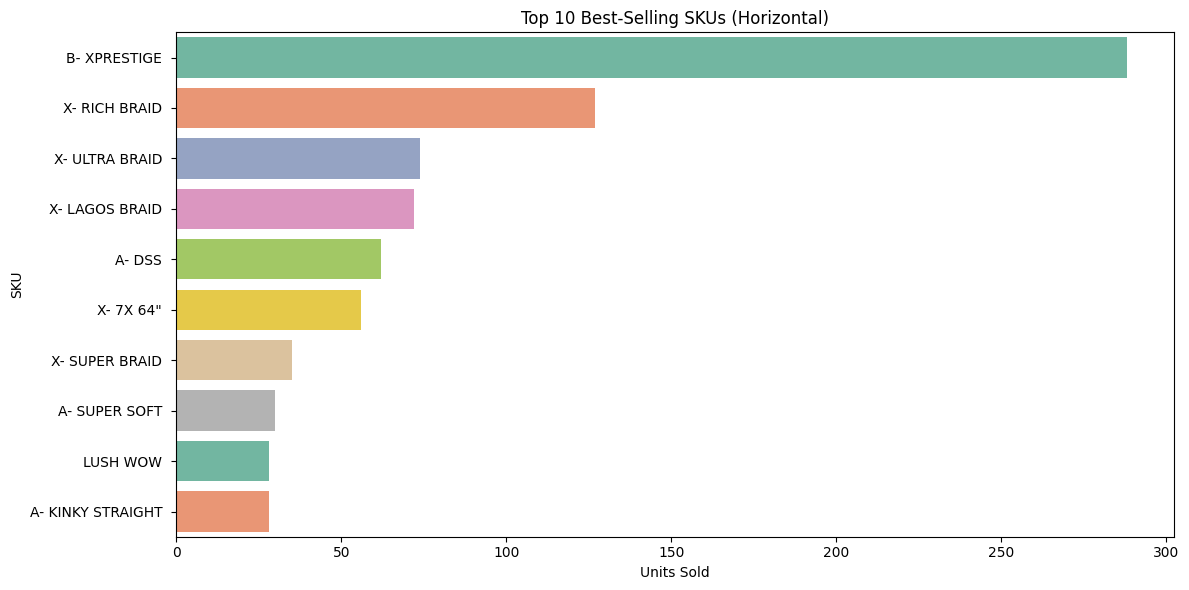

In [ ]:
top_skus_df = sku_summary.head(10).reset_index()
plt.figure(figsize=(12,6))
sns.barplot(data=top_skus_df, y="NormalizedSKU", x="TotalUnitsSold", palette=sns.color_palette("Set2", n_colors=len(top_skus_df)))
plt.title("Top 10 Best-Selling SKUs (Horizontal)")
plt.xlabel("Units Sold")
plt.ylabel("SKU")
plt.tight_layout()
plt.show()


/tmp/ipykernel_239/719146860.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x="NormalizedSKU", y="UnitPrice", palette="Set2")


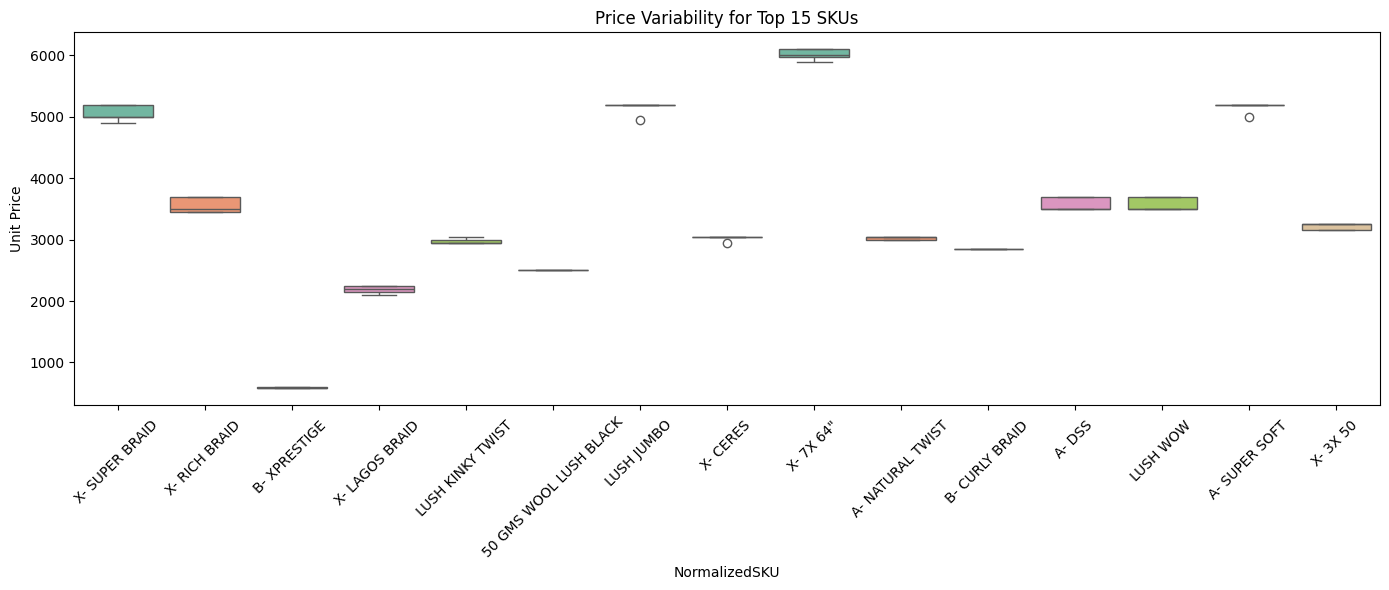

In [ ]:

top_skus = sales_df["NormalizedSKU"].value_counts().head(15).index
filtered_df = sales_df[sales_df["NormalizedSKU"].isin(top_skus)]

plt.figure(figsize=(14,6))
sns.boxplot(data=filtered_df, x="NormalizedSKU", y="UnitPrice", palette="Set2")
plt.xticks(rotation=45)
plt.title("Price Variability for Top 15 SKUs")
plt.ylabel("Unit Price")
plt.tight_layout()
plt.show()



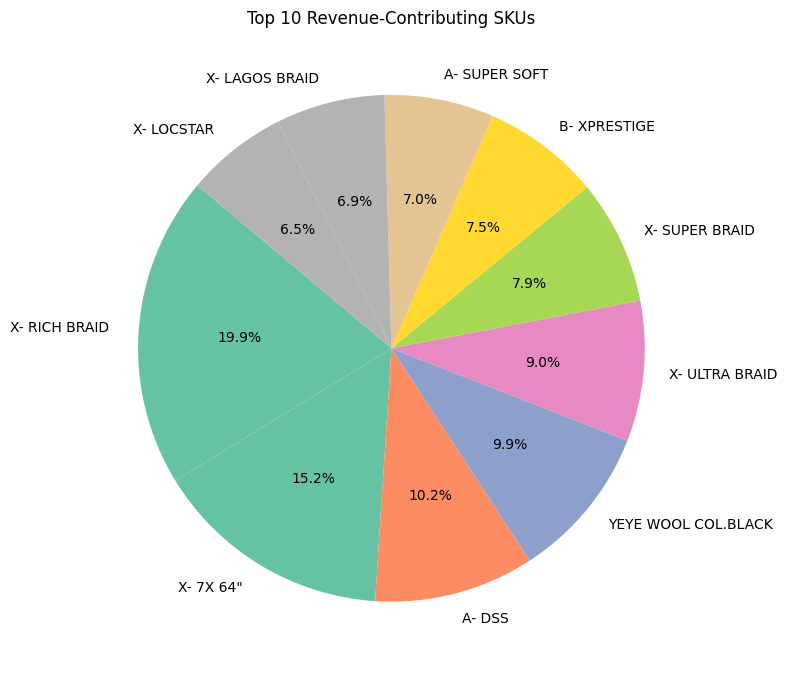

In [ ]:
sku_revenue = sales_df.groupby("NormalizedSKU")["Amount"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(8,8))
sku_revenue.plot.pie(autopct='%1.1f%%', startangle=140, colormap='Set2')
plt.ylabel("")
plt.title("Top 10 Revenue-Contributing SKUs")
plt.tight_layout()
plt.show()



In [ ]:
cart_value = sales_df.groupby("Receipt").agg(
    TotalSpent=("Amount", "sum"),
    TotalItems=("Qty", "sum")
)
print("\nAverage Cart Value: ₦{:.2f}".format(cart_value["TotalSpent"].mean()))




Average Cart Value: ₦41860.49


/tmp/ipykernel_239/3435546953.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=salesperson_perf, y="SalesPerson", x="TotalRevenue", palette=sns.color_palette("Set2", n_colors=len(salesperson_perf)))


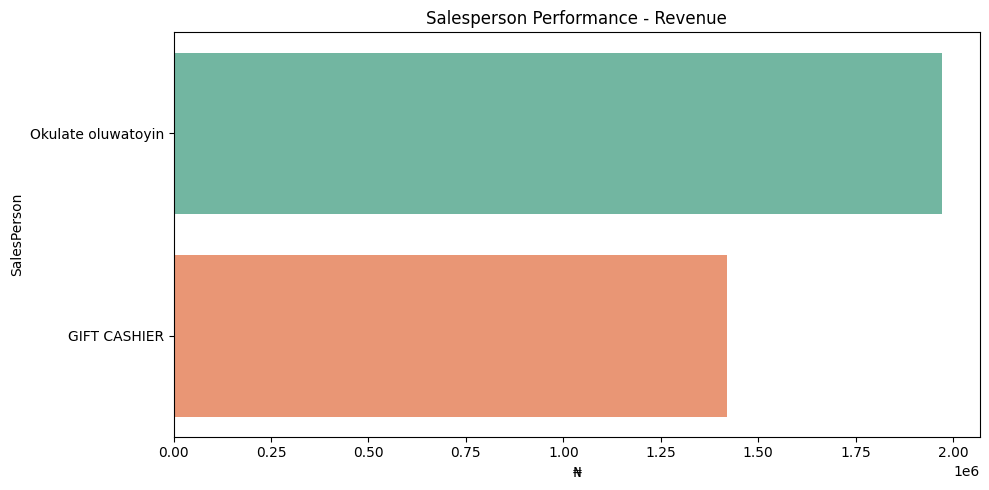

In [ ]:
salesperson_perf = sales_df.groupby("SalesPerson").agg(
    TotalRevenue=("Amount", "sum"),
    TotalTransactions=("Receipt", "nunique"),
    UnitsSold=("Qty", "sum")
).sort_values("TotalRevenue", ascending=False).reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=salesperson_perf, y="SalesPerson", x="TotalRevenue", palette=sns.color_palette("Set2", n_colors=len(salesperson_perf)))
plt.title("Salesperson Performance - Revenue")
plt.xlabel("₦")
plt.ylabel("SalesPerson")
plt.tight_layout()
plt.show()



/tmp/ipykernel_239/3222456572.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=low_margin_top_sellers, x="NormalizedSKU", y="AvgProfitPerUnit", palette=sns.color_palette("Set2", n_colors=len(low_margin_top_sellers)))


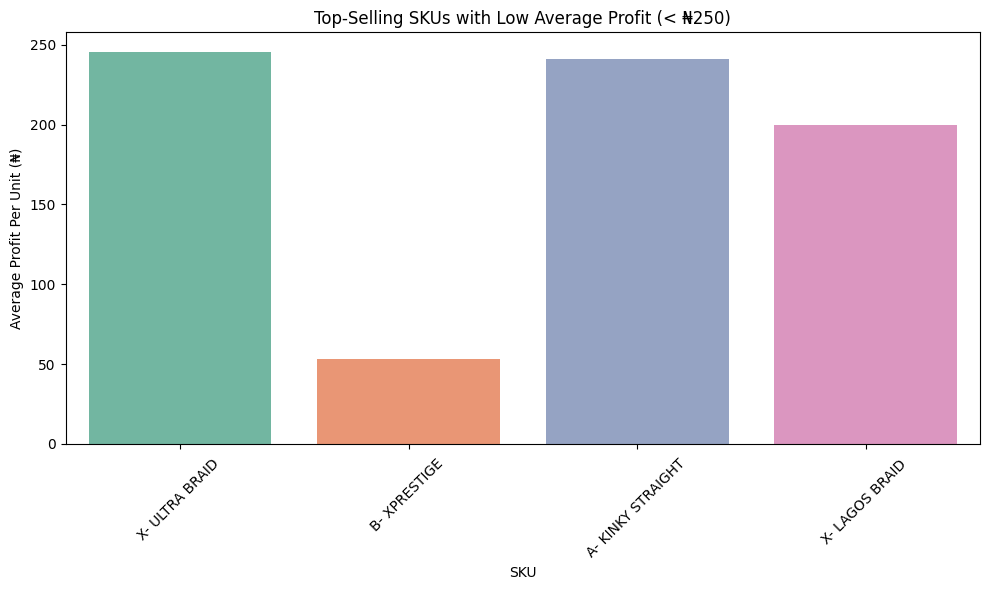

In [ ]:
low_margin = sku_summary[sku_summary["AvgProfitPerUnit"] < 250].copy()
low_margin.reset_index(inplace=True)
low_margin["NormalizedSKU"] = low_margin["NormalizedSKU"].astype(str)

low_margin_top_sellers = sku_summary.loc[overlap].reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=low_margin_top_sellers, x="NormalizedSKU", y="AvgProfitPerUnit", palette=sns.color_palette("Set2", n_colors=len(low_margin_top_sellers)))
plt.title("Top-Selling SKUs with Low Average Profit (< ₦250)")
plt.ylabel("Average Profit Per Unit (₦)")
plt.xlabel("SKU")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



/tmp/ipykernel_239/3478212599.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=high_margin_top_sellers, x="NormalizedSKU", y="AvgProfitPerUnit", palette=sns.color_palette("Set2", n_colors=len(high_margin_top_sellers)))


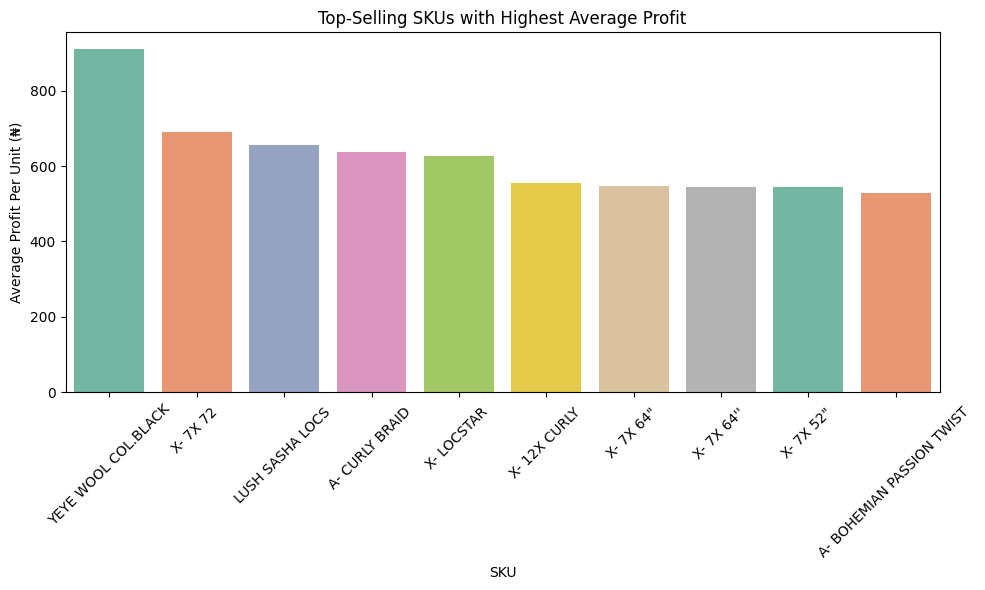

In [ ]:
high_margin = sku_summary.sort_values(by="AvgProfitPerUnit", ascending=False)
high_margin_top_sellers = high_margin.head(10).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=high_margin_top_sellers, x="NormalizedSKU", y="AvgProfitPerUnit", palette=sns.color_palette("Set2", n_colors=len(high_margin_top_sellers)))
plt.title("Top-Selling SKUs with Highest Average Profit")
plt.ylabel("Average Profit Per Unit (₦)")
plt.xlabel("SKU")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
sales_df.to_csv("structured_sales_data.csv", index=False)
sku_summary.to_csv("sku_summary_report.csv")
salesperson_perf.to_csv("salesperson_performance.csv")
sku_revenue.to_csv("sku_revenue_summary.csv")
cart_value.to_csv("cart_value_by_receipt.csv")
low_margin.to_csv("low_margin_skus.csv", index=False)